In [1]:
import cv2, numpy as np, pandas as pd, os, shutil, pickle as pkl
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model, load_model
from keras.applications.mobilenet_v2 import MobileNetV2
try: from keras.callbacks.callbacks import ModelCheckpoint
except:  from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

Using TensorFlow backend.


In [3]:
try:
    # to run on colab
    from google.colab import drive
    def mount_drive():
        drive.mount('/content/drive/')
    mount_drive()
    print("Runnning on GOOGLE COLAB")
    isCloud = True
except:
    print("Runnning on LOCAL SYSTEM")
    isCloud = False

Runnning on LOCAL SYSTEM


In [4]:
class HAM_Data:
    def __init__(self, images_path = "data/HAM10000_images/", data_info = "data/HAM10000_metadata.csv", split_files_path = "output/", resolution = (128, 128), toNormalize = True):
        extra = '/content/drive/My Drive/' if isCloud else  ""
        self.images_path = extra + images_path
        self.data_info = pd.read_csv(extra + data_info)
        self.operating_resolution = resolution
        self.toNormalize = toNormalize
        self.split_files_path = split_files_path
        self.get_training_info()
        
    def get_training_info(self, isShuffle = True):
        # change this according to data
        images_labels = self.data_info[['image_id', 'dx']]
        self.labels_dict = dict([(label, idx) for idx, label in enumerate(np.unique(images_labels['dx']))])
        self.n_classes = len(self.labels_dict)
        self.val_first = True
        
        if self.split_files_path == None:
            self.data = list()
            for idx, row in images_labels.iterrows():
                self.data.append([row[0], row[-1]])
            self.data = np.array(self.data)
            if isShuffle: np.random.shuffle(self.data)
            self.test_data = self.data[:int(len(self.data)*self.test_size)]
            self.train_data = self.data[int(len(self.data)*self.test_size):]
            self.val_data = self.train_data[:int(len(self.data)*self.val_size)]
            self.train_data = self.train_data[int(len(self.data)*self.val_size):]

            self.train_data = self.read_data(self.train_data)
            print("Read train data to memory")
            self.test_data = self.read_data(self.test_data)
            print("Read test data to memory")
            self.val_data = self.read_data(self.val_data)
            print("Read validation data to memory")
            for type_, data_ in zip(["train", "test", "val"], [self.train_data, self.test_data, self.val_data]):
                with open(os.path.join(self.save_path, type_ + ".pkl"), "wb") as f:
                    pkl.dump(data_, f)
        else:
            self.train_data = pkl.load(open(os.path.join(self.split_files_path, "train.pkl"), "rb"))
            self.test_data = pkl.load(open(os.path.join(self.split_files_path, "test.pkl"), "rb"))
            self.val_data = pkl.load(open(os.path.join(self.split_files_path, "val.pkl"), "rb"))
    
    def read_data(self, data):
        return np.array([np.array([self.read_image(image_id), self.labels_dict[label]]) for image_id, label in data])

    def path_from_id(self, image_id):
        return os.path.join(self.images_path, image_id + ".jpg")
    
    def read_image(self, image_id):
        image = cv2.resize(cv2.imread(self.path_from_id(image_id)), self.operating_resolution)
        if self.toNormalize: image = image.astype('float32') / 255.
        return image
                           
    def train_batch_generator(self, images_only = False):
        while True:
            start = self.batch_read_count
            end = (self.batch_read_count + self.batch_size) if (self.batch_read_count + self.batch_size) < len(self.train_data) else len(self.train_data)
            X, y = np.array([i for i in self.train_data[start:end][:,0]]), np.array([i for i in self.train_data[start:end][:,1]])
            self.batch_read_count += self.batch_size
            if self.batch_read_count >= len(self.train_data): self.batch_read_count = 0
            if not images_only: yield(X, y)
            else: yield(X, X)
            
    def val_batch_generator(self, images_only = False):
        while True:
            if self.val_first:
                np.random.shuffle(self.val_data)
                self.val_X, self.val_y = np.array([i for i in self.val_data[:,0]]), np.array([i for i in self.val_data[:,1]])
                self.val_first = False
            if not images_only: yield(self.val_X, self.val_y)
            else: yield(self.val_X, self.val_X)

In [5]:
class AutoEncoder:
    def __init__(self, encoding_dim = 300 , resolution = (128,128), trained_model_path = "backup/autoencoder-49-0.97.hdf5"):
        self.encoding_dimension = encoding_dim
        self.input_shape = tuple(list(resolution) + [3])
        self.model = None
        if trained_model_path != None:
            self.model = load_model(trained_model_path)
    
    def get_model(self):
        if self.model != None: return self.model
        input_layer = Input(shape=(self.input_shape))
        conv1 = Conv2D(16, (3,3), activation = 'relu', padding = 'same', name = "conv1")(input_layer)
        mp1 = MaxPooling2D((2,2), padding = 'same', name = "mp1")(conv1)
        conv2 = Conv2D(8, (3,3), activation = 'relu', padding = 'same', name = "conv2")(mp1)
        mp2 = MaxPooling2D((2,2), padding = 'same', name = "mp2")(conv2)
        conv3 = Conv2D(8, (3,3), activation = 'relu', padding = 'same', name = "conv3")(mp2)
        encoding = MaxPooling2D((2,2), padding = 'same', name = "encoding")(conv3)

        conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', name = "conv4")(encoding)
        up1 = UpSampling2D((2, 2), name = "up1")(conv4)
        conv5 = Conv2D(8, (3, 3), activation='relu', padding='same', name = "conv5")(up1)
        up2 = UpSampling2D((2, 2), name = "up2")(conv5)
        conv6 = Conv2D(16, (3, 3), activation='relu', padding='same', name = "conv6")(up2)
        up3 = UpSampling2D((2, 2), name = "up3")(conv6)
        recons = Conv2D(3, (3, 3), activation='relu', padding='same', name = "recons")(up3)
        self.model = Model(input_layer, recons)
        return self.model

class ImageClassifier:
    def __init__(self, n_classes, model_type = "mobilenet", resolution = (128,128), trained_model_path = None):
        self.model_type = model_type
        self.model = None
        if trained_model_path != None:
            self.model = load_model(trained_model_path)
        else:
            if "mobilenet" in self.model_type.lower():
                self.model = MobileNetV2(input_shape = tuple(list(resolution) + [3]), weights = None, classes = n_classes)

    def get_model(self):
        return self.model    

In [9]:
class Trainer(HAM_Data):
    def __init__(self, nn_type, save_path = "output/"):
        self.nn_type = nn_type
        extra = '/content/drive/My Drive/' if isCloud else  ""
        self.save_path = extra + save_path
        if not os.path.exists(self.save_path): os.mkdir(self.save_path)
        self.train_config()
        HAM_Data.__init__(self)
        self.determine_model()
    
    def determine_model(self):
        if "autoencoder" in self.nn_type.lower():
            self.ae = AutoEncoder(resolution = self.operating_resolution)
            self.model = self.ae.get_model()
            self.train = self.train_autoencoder
            self.test = self.test_autoencoder
        elif "classifier" in self.nn_type.lower():
            self.ic = ImageClassifier(n_classes = self.n_classes, model_type = "mobilenet", resolution = self.operating_resolution)
            self.model = self.ic.get_model()
            self.train = self.train_classifier
            self.test = self.test_classifier
    
    def train_config(self, model_name = ""):
        self.batch_size = 32
        self.mini_batch_size = 16
        self.epochs = 50
        self.test_size = 0.2
        self.val_size = 0.1
        
        self.operating_resolution = (128,128)
        self.batch_read_count = 0
        
        self.model_name = os.path.join(self.save_path, self.nn_type + "-{epoch:02d}-{val_accuracy:.2f}.hdf5")
        self.callback = [ModelCheckpoint(self.model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
    
    def train_classifier(self):
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])        
        self.model.fit_generator(self.train_batch_generator(), validation_data = self.val_batch_generator(), epochs = self.epochs, steps_per_epoch = int(len(self.train_data) / self.batch_size), shuffle = True, validation_steps = 1, callbacks = callback)
    
    def train_autoencoder(self):
        self.model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
        self.model.fit_generator(self.train_batch_generator(True), validation_data = self.val_batch_generator(True), epochs = self.epochs, steps_per_epoch = int(len(self.train_data) / self.batch_size), shuffle = True, validation_steps = 1, callbacks = self.callback)
        
    def test_autoencoder(self, random_test_count = 10):
        for idx, original_image in enumerate(np.random.choice(self.test_data[:,0], random_test_count)):
            reconstructed_image = np.squeeze(self.model.predict(np.expand_dims(original_image, axis = 0)))
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(original_image)
            ax[1].imshow(reconstructed_image)
            plt.show()

In [10]:
t = Trainer(nn_type = "autoencoder")

### Results of a simple De-Noising autoencoder with MSE loss on HAM10000 data

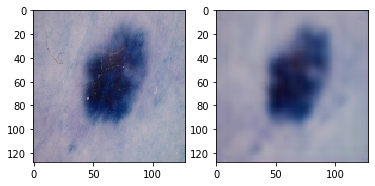

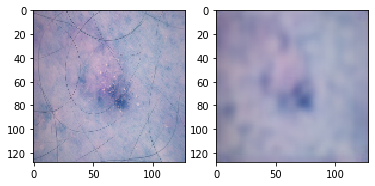

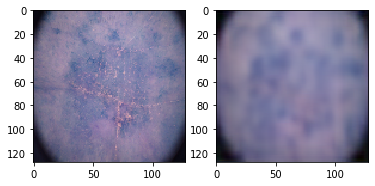

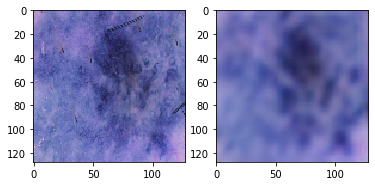

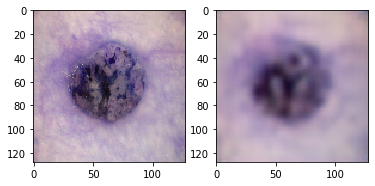

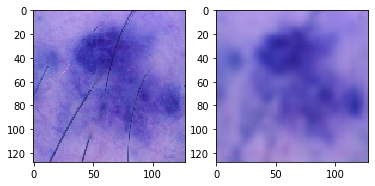

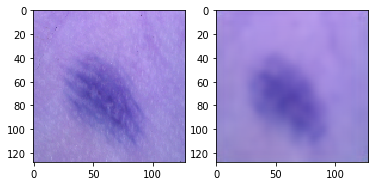

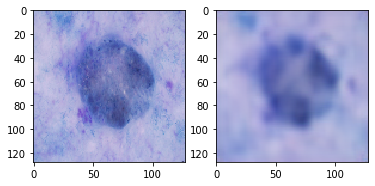

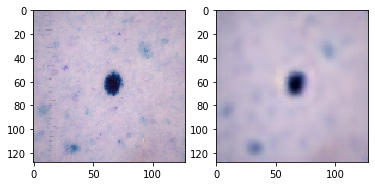

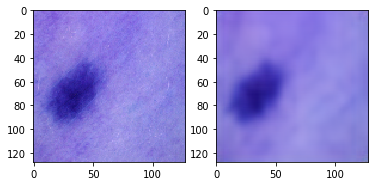

In [11]:
t.test()